In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_context("poster")
plt.rcParams['pdf.fonttype'] = 42

## Determine significant promoter responses <a name="Z test"></a>

In [2]:
# q-value method (Storey and Tibshirani, 2003)
from scipy.interpolate import UnivariateSpline
def qvalue(pvals):
    m, pvals = len(pvals), np.asarray(pvals)
    ind = np.argsort(pvals)
    rev_ind = np.argsort(ind)
    pvals = pvals[ind]

    # Estimate proportion of features that are truly null.
    kappa = np.arange(0, 0.96, 0.01)
    pik = [sum(pvals > k) / (m*(1-k)) for k in kappa]
    cs = UnivariateSpline(kappa, pik, k=3, s=None, ext=0)
    pi0 = float(cs(1.))
    print('The estimated proportion of truly null features is %.3f' % pi0)

    if (pi0 < 0 or pi0 > 1):
        pi0 = 1
        print('Smoothing estimator did not converge in [0, 1]')

    # Compute the q-values.
    qvals = np.zeros(np.shape(pvals))
    qvals[-1] = pi0*pvals[-1]
    for i in np.arange(m-2, -1, -1):
        qvals[i] = min(pi0*m*pvals[i]/float(i+1), qvals[i+1])

    # Order the q-values according to the original order of the p-values.
    qvals = qvals[rev_ind]
    return qvals

def Ztest_DEG(exp,nc):
    # exp: experimental group, nc: negative control group
    num_sgRNA = exp['sgRNA'].nunique()
    var_nc = (nc['std']**2/nc['n_rep'] + 1/2 * nc['std']**4/(nc['n_rep']-1)).repeat(num_sgRNA)
    var_nc = var_nc.reset_index(drop=True)
    var_exp = exp['std']**2/exp['n_rep'] + 1/2 * exp['std']**4/(exp['n_rep']-1)
    # calculate fold change
    FC = exp['mean'] - nc['mean'].repeat(num_sgRNA).reset_index(drop=True)
    FC_over_median = exp['mean'] - exp.groupby(['operon'])['mean'].median().repeat(num_sgRNA).reset_index(drop=True)
    # calculate Z score based on Zhou et al., 1997 Biometrics 53, 1129
    Z = FC/(np.sqrt(var_exp + var_nc))
    # calculate p value from Z score
    pvals = scipy.stats.norm.sf(abs(Z))*2
    # adjust the pvalue for multiple hypothesis test using q value method
    qvals = qvalue(pvals)
    # convert natural log fold change to log2 fold change
    exp['FC'] = FC/np.log(2)
    exp['FCOM'] = FC_over_median/np.log(2)
    # convert very small p values to 1e-10
    exp['-logP'] = -np.log10(qvals+1e-10)
    # divide the variants into three classes
    # 1: up regulated, -1: down regulated, 0: not significant
    exp['class'] = 0
    exp.loc[(exp['FC']>np.log2(1.7)) & (exp['FCOM']>np.log2(1.7)) & (exp['-logP']>2),'class'] = 1
    exp.loc[(exp['FC']<-np.log2(1.7)) & (exp['FCOM']<-np.log2(1.7)) & (exp['-logP']>2),'class'] = -1
    return exp

In [3]:
# load data
# read sort-seq data
log_GFP = pd.read_csv('../Processed_data/normalized_stat_exp.csv')
log_GFP_nc = pd.read_csv('../Processed_data/normalized_stat_nc.csv')
# differential expression analysis
DE_analysis_full_df = Ztest_DEG(log_GFP,log_GFP_nc)
DE_analysis_full_df.rename(columns={'sgRNA': 'tf_gene'}, inplace=True)

# calculate global effect
median_FC_operon = DE_analysis_full_df.groupby('operon')['FC'].median()
median_FC_tf = DE_analysis_full_df.groupby('tf_gene')['FC'].median()
DE_analysis_full_df = DE_analysis_full_df[DE_analysis_full_df['operon'].isin(median_FC_operon[median_FC_operon.notna()].index)].reset_index(drop = True)
DE_analysis_full_df['FC_global'] = pd.concat([median_FC_tf]*DE_analysis_full_df['operon'].nunique()).reset_index()['FC']
DE_analysis_full_df['FC_specific'] = DE_analysis_full_df['FC'] - DE_analysis_full_df['FC_global']

# remove sgRNAs that directly target TF promoters
self_targeting_sgRNA = pd.read_csv('../Processed_data/promoter-targeting_sgRNAs.txt', sep = '\t')
self_targeting_sgRNA.set_index(['operon','tf_gene'], inplace = True)
DE_analysis_full_df.set_index(['operon','tf_gene'], inplace = True)
DE_analysis_full_df = DE_analysis_full_df[~DE_analysis_full_df.index.isin(self_targeting_sgRNA.index)].reset_index()

The estimated proportion of truly null features is 0.529


,operon,tf_gene,mean,std,std_linear,n_rep,FC,FCOM,-logP,class,FC_global,FC_specific
8560,argG,argR,8.714986,0.197767,1166.120093,3,1.405137,1.384271,9.999572,1,0.588011,0.817127
38978,fadE,fadR,8.912815,0.235562,1740.878445,3,2.166803,2.175972,10.000000,1,-0.086015,2.252819
66491,ilvIH,lrp,7.724078,0.276489,629.456636,2,-1.375694,-1.327560,4.185698,-1,0.150204,-1.525897
74673,lacZYA,lacI,9.591233,0.050565,747.776355,3,3.630539,3.561111,10.000000,1,0.142567,3.487973
81961,marRAB,marR,8.866800,0.158885,1181.282106,3,0.858708,0.879735,4.986150,1,-0.052121,0.910829
84150,metE,metR,8.132727,0.205215,664.022969,3,-2.714426,-2.558168,10.000000,-1,0.180902,-2.895327


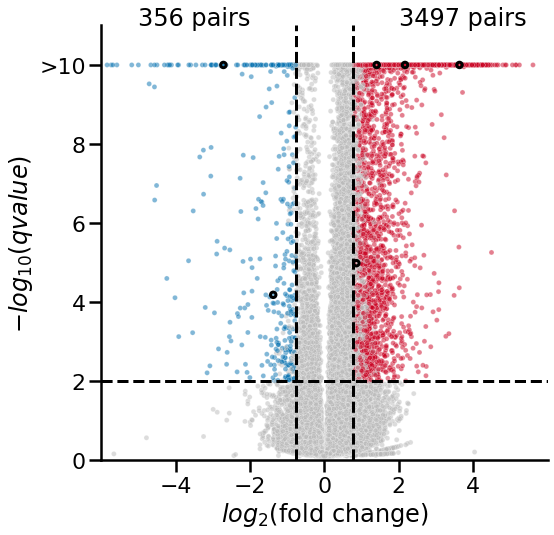

In [4]:
# Fig. 2a
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
x_limits = [-6,6]
y_limits = [0,11]
y_cutoff = 2
x_cutoff = np.log2(1.7)
consistence_cutoff = 0.7
dataset = DE_analysis_full_df[(DE_analysis_full_df['std']<consistence_cutoff)]
kws = {"s": 30, "facecolor": "none", "linewidth": 3}
sns.scatterplot(data = dataset, 
                x = 'FC', 
                y = '-logP', 
                hue='class', 
                s = 25, alpha = 0.5, palette=['#0571B0','#BABABA','#CA0020'], ax=ax)
sns.scatterplot(data = dataset.loc[[8560,38978,66491,74673,81961,84150]], x = 'FC', y = '-logP', edgecolor= 'k', **kws, ax=ax)
ax.plot(x_limits,[y_cutoff,y_cutoff],'k--')
ax.plot([x_cutoff,x_cutoff],y_limits,'k--')
ax.plot([-x_cutoff,-x_cutoff],y_limits,'k--')
ax.legend().remove()
sns.despine(bottom = False, left = False)
ax.annotate("{} pairs".format(dataset[dataset['class']==1].shape[0]), (2, 11))
ax.annotate("{} pairs".format(dataset[dataset['class']==-1].shape[0]), (-5, 11))
ax.set(xlim=x_limits, 
       ylim=y_limits,
       yticks = [0,2,4,6,8,10],
       yticklabels = [0,2,4,6,8,'>10'],
       xticks = [-4,-2,0,2,4],
       xlabel = "$log_{2}$(fold change)", 
       ylabel = "$-log_{10}(q value)$",
      );
# a few known regulatory interactions
dataset.loc[[8560,38978,66491,74673,81961,84150]]

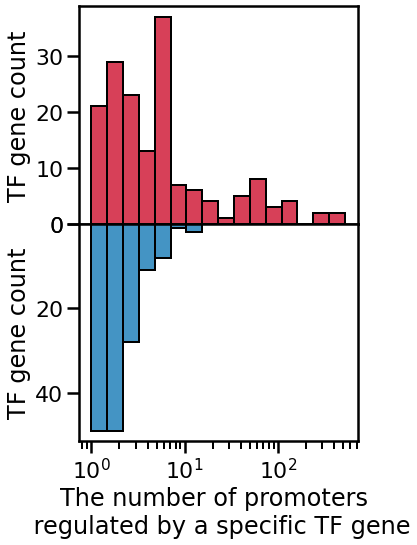

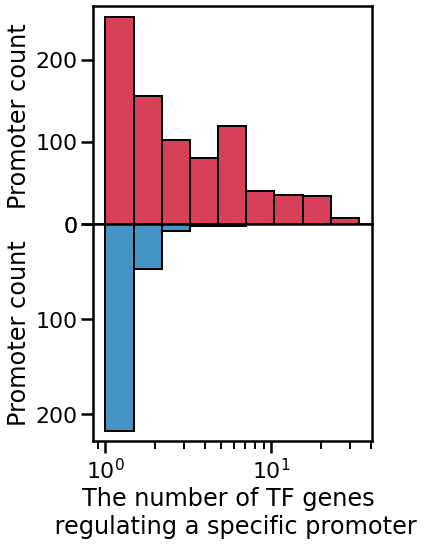

In [5]:
# Fig. 2b
fig, axes = plt.subplots(figsize=(5,8), nrows=2, sharex=True)
classes = [1,-1]
colors = ['#CA0020','#0571B0']
for i in range(2):
    sns.histplot(dataset[dataset['class']==classes[i]]['tf_gene'].value_counts(), 
                 color=colors[i], 
                 bins=25, 
                 binwidth=0.17, 
                 log_scale=True, 
                 ax = axes[i])
axes[0].set(ylabel = "TF gene count")
axes[1].set(xlabel = "The number of promoters \n regulated by a specific TF gene", ylabel = "TF gene count");
axes[1].invert_yaxis()
plt.subplots_adjust(hspace=0)

# Fig. 2c
fig, axes = plt.subplots(figsize=(5,8), nrows=2, sharex=True)
for i in range(2):
    sns.histplot(dataset[dataset['class']==classes[i]]['operon'].value_counts(), 
                 color=colors[i], 
                 bins=25, 
                 binwidth=0.17, 
                 log_scale=True, 
                 ax = axes[i])
axes[0].set(ylabel = "Promoter count")
axes[1].set(xlabel = "The number of TF genes \n regulating a specific promoter", ylabel = "Promoter count");
axes[1].invert_yaxis()
plt.subplots_adjust(hspace=0)

# Functional enrichment

COG functional annotation is used

In [6]:
def read_COG_anno_ECO():
    #load COG annotation for E. coli operons
    file_path = '../External_data/gene_annotation/operon_cog_map.txt'
    column_name = ['operon', 'COG_cat','count']
    ECO_COG_df = pd.read_csv(file_path, sep="\t", names = column_name)

    #load COG annotation for conversion from category to full name
    file_path = '../External_data/gene_annotation/fun-20.tab.txt'
    column_name = ['COG_cat', 'color','name']
    COG_func_df = pd.read_csv(file_path, sep="\t", names = column_name)
    return ECO_COG_df,COG_func_df

In [7]:
# import COG annotation
ECO_COG,COG_func = read_COG_anno_ECO()
COG2name = pd.Series(COG_func.name.values,index=COG_func.COG_cat).to_dict()
# define variable promoters and constant promoters
DE_only_df = DE_analysis_full_df[(DE_analysis_full_df['class']!=0)
                                # only consider specific effects when determining variable promoters
                                & (abs(DE_analysis_full_df['FC_specific'])>np.log2(1.7)) 
                                & ((DE_analysis_full_df['std'])<0.7)].reset_index(drop = True)
# calculate the number of variable promoters and constant promoters in each COG class
COG_anno_df = ECO_COG[ECO_COG['operon'].isin(DE_analysis_full_df['operon'].unique())].reset_index(drop = True)
COG_anno_df_responsive = ECO_COG[ECO_COG['operon'].isin(DE_only_df['operon'].unique())].reset_index(drop = True)
promoter_COG_cat_count_df = pd.concat([COG_anno_df['COG_cat'].value_counts().rename('total'),
                                       COG_anno_df_responsive['COG_cat'].value_counts().rename('variable')],
                                      axis = 1)
promoter_COG_cat_count_df['constant'] = promoter_COG_cat_count_df['total'] - promoter_COG_cat_count_df['variable']
promoter_COG_cat_count_df['COG_name'] = promoter_COG_cat_count_df.index.map(COG2name)

In [8]:
# enrichment analysis using Fisher's exact test
M = promoter_COG_cat_count_df['total'].sum() # M: total number of annotated COG functions
n = promoter_COG_cat_count_df['total'] # n: total number of COG functions annotated as the "COG_cat"
N_v = promoter_COG_cat_count_df['variable'].sum() # N: total number of annotated COG functions in the gene set
x_v = promoter_COG_cat_count_df['variable'] # x: total number of COG functions annotated as the "COG_cat" in the gene set
N_c = promoter_COG_cat_count_df['constant'].sum() # N: total number of annotated COG functions in the gene set
x_c = promoter_COG_cat_count_df['constant'] # x: total number of COG functions annotated as the "COG_cat" in the gene set
promoter_COG_cat_count_df['v_ratio'] = promoter_COG_cat_count_df['variable']/promoter_COG_cat_count_df['total']
promoter_COG_cat_count_df['c_ratio'] = promoter_COG_cat_count_df['constant']/promoter_COG_cat_count_df['total']
c_ratio = 1 - DE_only_df['operon'].nunique()/DE_analysis_full_df['operon'].nunique()
from scipy.stats import hypergeom
promoter_COG_cat_count_df['v_pvalue'] = hypergeom.sf(x_v, M, n, N_v) + hypergeom.pmf(x_v, M, n, N_v)
promoter_COG_cat_count_df['c_pvalue'] = hypergeom.sf(x_c, M, n, N_c) + hypergeom.pmf(x_c, M, n, N_c)
promoter_COG_cat_count_df = promoter_COG_cat_count_df.sort_values(by='c_ratio')
promoter_COG_cat_count_df

,total,variable,constant,COG_name,v_ratio,c_ratio,v_pvalue,c_pvalue
W,11,9,2,Extracellular structures,0.818182,0.181818,0.144480,0.961075
D,18,14,4,"Cell cycle control, cell division, chromosome ...",0.777778,0.222222,0.122155,0.954995
U,22,17,5,"Intracellular trafficking, secretion, and vesi...",0.772727,0.227273,0.097797,0.961929
V,48,37,11,Defense mechanisms,0.770833,0.229167,0.017554,0.992536
N,26,20,6,Cell motility,0.769231,0.230769,0.078872,0.968066
G,128,90,38,Carbohydrate transport and metabolism,0.703125,0.296875,0.023835,0.985230
Q,22,15,7,"Secondary metabolites biosynthesis, transport ...",0.681818,0.318182,0.352211,0.796974
K,184,120,64,Transcription,0.652174,0.347826,0.179289,0.860066
M,121,77,44,Cell wall/membrane/envelope biogenesis,0.636364,0.363636,0.374842,0.696487
L,82,52,30,"Replication, recombination and repair",0.634146,0.365854,0.430069,0.659194


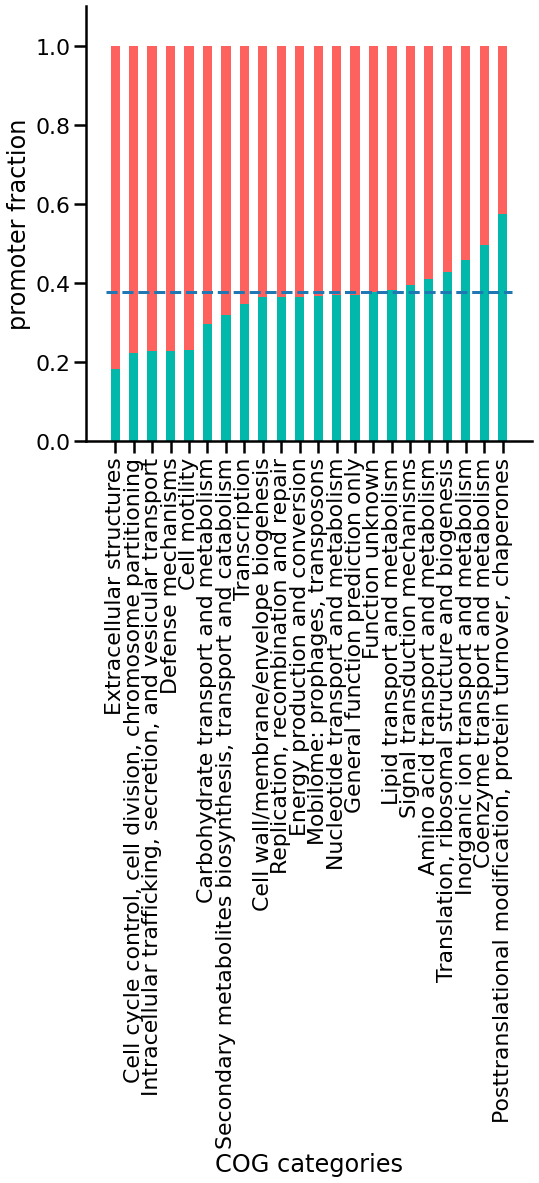

In [9]:
# Fig. 2d
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.bar(promoter_COG_cat_count_df.COG_name, promoter_COG_cat_count_df['c_ratio'], 
       color = '#01b8aa', width=0.5, label = 'Constant promoters')
ax.bar(promoter_COG_cat_count_df.COG_name, promoter_COG_cat_count_df['v_ratio'], 
       color = '#fd625e', width=0.5, bottom = promoter_COG_cat_count_df['c_ratio'], label = 'Variable promoters')
ax.plot([-0.5,21.5], [c_ratio,c_ratio], '--')
plt.xticks(rotation=90)
ax.set(ylabel = 'promoter fraction', xlabel = 'COG categories', ylim = [0,1.1]);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)